<a href="https://colab.research.google.com/github/ARMINPAN/Advance-Neuroscience-Final-Project/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# advance neuro project

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import torch

In [11]:
# select the device to run the code on
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu" 

In [12]:
def ReLU(x):
    zeros_mat = torch.zeros(x.shape, device=dev)
    output = torch.fmax(x, zeros_mat)
    return output

In [13]:
def ReLU_deriv(x):
    non_negs = torch.where(x >= 0)
    output = torch.zeros(x.shape, device=dev)
    output[non_negs] = 1
    return output

In [14]:
def angleCal(A, B):
    num = torch.trace(torch.matmul(torch.conj(A.T), B))
    norm_A = math.sqrt(torch.trace(torch.matmul(A,torch.conj(A.T))))
    norm_B = math.sqrt(torch.trace(torch.matmul(B,torch.conj(B.T))))
    denum = norm_A*norm_B
    angle = torch.arccos(num/denum)*180/math.pi
    return angle

In [6]:
#### network parameters - open loop 2 layer network - first condition - auto correlated 

mu = 0
sigma = 1
LR = 0.002
n_b = 100 # batch size
number_of_iterations = 2000


input_layer_size = 20
hidden_layer1_size = 100
output_layer_size = 20

# updating the network parameters
epoch_num = 10
angles1 = torch.zeros((epoch_num, number_of_iterations), device=dev)

for k in range (epoch_num):
    forward_weight_0 = torch.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size), device=dev)
    forward_weight_1 = torch.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size), device=dev)
    backward_weight_1 = torch.normal(mu, sigma, size=(output_layer_size,hidden_layer1_size), device=dev)
    
    # input layer values - # move on gpu
    input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) # initial value of inputs - constant during iterations
    error_delta2 = torch.normal(mu, sigma, size=(n_b, output_layer_size), device=dev) # initial value of error_delta 2 - constant during iterations
    error_delta1 = torch.matmul(error_delta2, backward_weight_1) # initial value of error_delta1 - constant during iterations since
    
    for j in range (number_of_iterations):
        angles1[k,j] = angleCal(forward_weight_1, backward_weight_1.T)
        Z1 = torch.matmul(input_layer, forward_weight_0)
        hidden_layer_1 = ReLU(Z1)
        delta1 = torch.multiply(error_delta1,ReLU_deriv(Z1))
        delta_w0 = LR*torch.matmul(input_layer.T, delta1)
        delta2 = error_delta2
        delta_w1 = LR*torch.matmul(hidden_layer_1.T, delta2)
        forward_weight_0 += delta_w0
        forward_weight_1 += delta_w1
        
print('simulation finished, please run the next section for the result')

simulation finished, please run the next section for the result


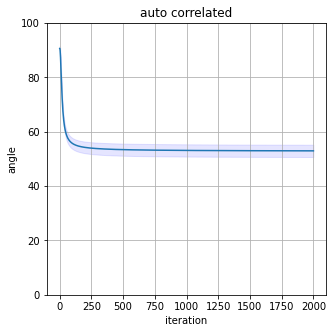

In [7]:
## plot the result of auto correlated mode(prev part's result)

    
fig, ax = plt.subplots(1,1,figsize=(5,5));
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles1.cpu().numpy(),0));
ax.set_ylim([0, 100]);
ax.set_title('auto correlated');
ax.set_ylabel('angle');
ax.set_xlabel('iteration');
ax.grid(True);

# plot the condfidence interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles1.cpu().numpy(),0)-np.std(angles1.cpu().numpy(),axis=0),\
                np.mean(angles1.cpu().numpy(),0)+np.std(angles1.cpu().numpy(),axis=0),\
                color='b', alpha=.1);


In [8]:
#### network parameters - open loop 2 layer network - second condition - cross correlated 

mu = 0
sigma = 1
LR = 0.002
n_b = 100 # batch size
number_of_iterations = 2000


input_layer_size = 20
hidden_layer1_size = 100
output_layer_size = 20

# updating the network parameters
epoch_num = 10
angles2 = torch.zeros((epoch_num, number_of_iterations), device=dev)

for k in range (epoch_num):
    forward_weight_0 = torch.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size), device=dev)
    forward_weight_1 = torch.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size), device=dev)
    backward_weight_1 = torch.normal(mu, sigma, size=(output_layer_size,hidden_layer1_size), device=dev)

    # input layer values
    input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) 
    error_delta2 = torch.clone(input_layer) # cross correlated with inputs of network
    error_delta1 = torch.matmul(error_delta2, backward_weight_1) 
    
    for j in range (number_of_iterations):
        angles2[k,j] = angleCal(forward_weight_1, backward_weight_1.T)
        Z1 = torch.matmul(input_layer, forward_weight_0)
        hidden_layer_1 = ReLU(Z1)
        delta1 = torch.multiply(error_delta1,ReLU_deriv(Z1))
        delta_w0 = LR*torch.matmul(input_layer.T, delta1)
        delta2 = torch.clone(error_delta2)
        delta_w1 = LR*torch.matmul(hidden_layer_1.T, delta2)
        forward_weight_0 += delta_w0
        forward_weight_1 += delta_w1
        # generate the parameters again
        input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) 
        error_delta2 = torch.clone(input_layer)
        error_delta1 = torch.matmul(error_delta2, backward_weight_1) 
        
print('simulation finished, please run the next section for the result')

simulation finished, please run the next section for the result


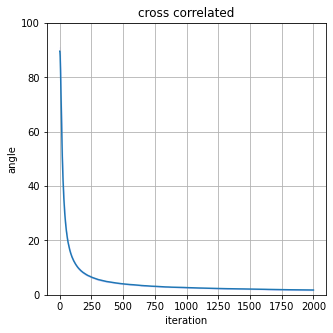

In [9]:
# plot the result of cross correlated mode(prev part's result)

    
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles2.cpu().numpy(),0))
ax.set_ylim([0, 100])
ax.set_title('cross correlated')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)

# plot the condfidence interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles2.cpu().numpy(),0)-np.std(angles2.cpu().numpy(),axis=0),\
                np.mean(angles2.cpu().numpy(),0)+np.std(angles2.cpu().numpy(),axis=0),\
                color='b', alpha=.1);


In [10]:
#### network parameters - open loop 2 layer network - third condition - not auto correlated nor cross correlated

mu = 0
sigma = 1
LR = 0.002
n_b = 100 # batch size
number_of_iterations = 2000


input_layer_size = 20
hidden_layer1_size = 100
output_layer_size = 20

# updating the network parameters
epoch_num = 10
angles3 = torch.zeros((epoch_num, number_of_iterations), device=dev)

for k in range (epoch_num):
    forward_weight_0 = torch.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size), device=dev)
    forward_weight_1 = torch.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size), device=dev)
    backward_weight_1 = torch.normal(mu, sigma, size=(output_layer_size,hidden_layer1_size), device=dev)

    # input layer values
    input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) 
    error_delta2 = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) 
    error_delta1 = torch.matmul(error_delta2, backward_weight_1)

    for j in range (number_of_iterations):
        angles3[k,j] = angleCal(forward_weight_1, backward_weight_1.T)
        Z1 = torch.matmul(forward_weight_0.T, input_layer.T).T
        hidden_layer_1 = ReLU(Z1)
        delta1 = torch.multiply(error_delta1,ReLU_deriv(Z1))
        delta_w0 = LR*torch.matmul(input_layer.T, delta1)
        delta2 = error_delta2
        delta_w1 = LR*torch.matmul(hidden_layer_1.T, delta2)
        forward_weight_0 += delta_w0
        forward_weight_1 += delta_w1
        # generate the parameters again
        input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) 
        error_delta2 = torch.normal(mu, sigma, size=(n_b, output_layer_size), device=dev) 
        error_delta1 = torch.matmul(error_delta2, backward_weight_1) 
        
print('simulation finished, please run the next section for the result')

simulation finished, please run the next section for the result


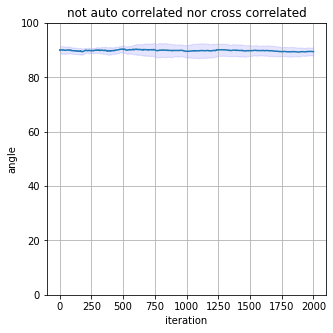

In [11]:
# plot the result of not auto correlated nor cross correlated mode(prev part's result)

    
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles3.cpu().numpy(),0))
ax.set_ylim([0, 100])
ax.set_title('not auto correlated nor cross correlated')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)

# plot the condfidence interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles3.cpu().numpy(),0)-np.std(angles3.cpu().numpy(),axis=0),\
                np.mean(angles3.cpu().numpy(),0)+np.std(angles3.cpu().numpy(),axis=0),\
                color='b', alpha=.1);


In [12]:
#### network parameters - open loop 2 layer network - forth condition - auto correlated & cross correlated

mu = 0
sigma = 1
LR = 0.002
n_b = 100 # batch size
number_of_iterations = 2000


input_layer_size = 20
hidden_layer1_size = 100
output_layer_size = 20

# updating the network parameters
epoch_num = 10
angles4 = torch.zeros((epoch_num, number_of_iterations), device=dev)

for k in range (epoch_num):
    forward_weight_0 = torch.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size), device=dev)
    forward_weight_1 = torch.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size), device=dev)
    backward_weight_1 = torch.normal(mu, sigma, size=(output_layer_size,hidden_layer1_size), device=dev)

    # input layer values
    input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) # initial value of inputs - constant during iterations
    error_delta2 = input_layer # initial value of error_delta 2 - constant during iterations
    error_delta1 = torch.matmul(error_delta2, backward_weight_1) # initial value of error_delta1 - constant during iterations since
    # delta 2 doesn't change

    for j in range (number_of_iterations):
        angles4[k,j] = angleCal(forward_weight_1, backward_weight_1.T)
        Z1 = torch.matmul(input_layer, forward_weight_0)
        hidden_layer_1 = ReLU(Z1)
        delta1 = torch.multiply(error_delta1,ReLU_deriv(Z1))
        delta_w0 = LR*torch.matmul(input_layer.T, delta1)
        delta2 = error_delta2
        delta_w1 = LR*torch.matmul(hidden_layer_1.T, delta2)
        forward_weight_0 += delta_w0
        forward_weight_1 += delta_w1
        
print('simulation finished, please run the next section for the result')

simulation finished, please run the next section for the result


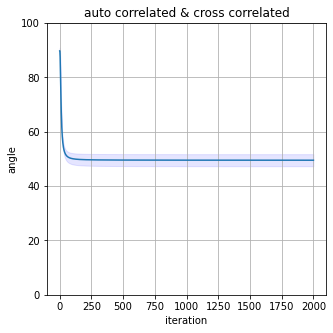

In [13]:
# plot the result of auto correlated & cross correlated mode(prev part's result)

    
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles4.cpu().numpy(),0))
ax.set_ylim([0, 100])
ax.set_title('auto correlated & cross correlated')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)

# plot the condfidence interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles4.cpu().numpy(),0)-np.std(angles4.cpu().numpy(),axis=0),\
                np.mean(angles4.cpu().numpy(),0)+np.std(angles4.cpu().numpy(),axis=0),\
                color='b', alpha=.1);


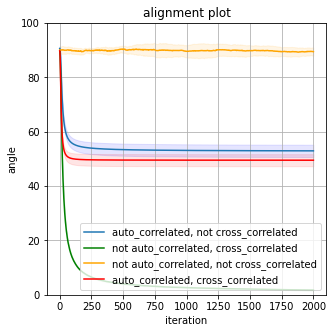

In [14]:
# plot the result of all three conditions together

    
fig, ax = plt.subplots(1,1,figsize=(5,5))

# condition 1
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles1.cpu().numpy(),0))
ax.set_ylim([0, 100])
ax.set_title('alignment plot')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)
# plot the condfidence1 interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles1.cpu().numpy(),0)-np.std(angles1.cpu().numpy(),axis=0),\
                np.mean(angles1.cpu().numpy(),0)+np.std(angles1.cpu().numpy(),axis=0),\
                color='b', alpha=.1);

# condition 2
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles2.cpu().numpy(),0),color='green')
ax.set_ylim([0, 100])
ax.set_title('alignment plot')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)
# plot the condfidence2 interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles2.cpu().numpy(),0)-np.std(angles2.cpu().numpy(),axis=0),\
                np.mean(angles2.cpu().numpy(),0)+np.std(angles2.cpu().numpy(),axis=0),\
                color='green', alpha=.1);

# condition 3
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles3.cpu().numpy(),0),color='orange')
ax.set_ylim([0, 100])
ax.set_title('alignment plot')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)
# plot the condfidence3 interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles3.cpu().numpy(),0)-np.std(angles3.cpu().numpy(),axis=0),\
                np.mean(angles3.cpu().numpy(),0)+np.std(angles3.cpu().numpy(),axis=0),\
                color='orange', alpha=.1);

# condition 4
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles4.cpu().numpy(),0),color='red')
ax.set_ylim([0, 100])
ax.set_title('alignment plot')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)
# plot the condfidence4 interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles4.cpu().numpy(),0)-np.std(angles4.cpu().numpy(),axis=0),\
                np.mean(angles4.cpu().numpy(),0)+np.std(angles4.cpu().numpy(),axis=0),\
                color='red', alpha=.1);

ax.legend(['auto_correlated, not cross_correlated','not auto_correlated, cross_correlated',\
           'not auto_correlated, not cross_correlated',\
          'auto_correlated, cross_correlated'],loc='lower right')

In [15]:
# Paper Part - 2.3 Using the provided theoretical tool to investigate FA in the learning process of a practical deep ANN
# train and test a 5 layer network on MNIST
# fact = tanh(ReLU) - 50 neurons in all hidden and output layer - output layer is using 5 hot coding
# images of MNIST should be resized to 15*15 - so we have 225 neurons in input layer 
# inputs should be normalized 
# batch size = 1000, 60 batches available (total numbre of 60K images)
# initialization of forward/ backward weights and biases is done using N(0,0.1)
# loss function is sth like squared error, check page 5 for the details

In [15]:
def n_hot_coder(x,n,hot_labels,output_neuron_num):
    labels = x.cpu().numpy()
    category_num = 10
    if(category_num*n > output_neuron_num):
        print('nhot encoding can`t be done since the condition`s not met')
        return false
    
    output = torch.zeros((len(x),output_neuron_num), device=dev)
    
    output[np.where(labels == 0),:] = hot_labels[0,:]
    output[np.where(labels == 1),:] = hot_labels[1,:]
    output[np.where(labels == 2),:] = hot_labels[2,:]
    output[np.where(labels == 3),:] = hot_labels[3,:]
    output[np.where(labels == 4),:] = hot_labels[4,:]
    output[np.where(labels == 5),:] = hot_labels[5,:]
    output[np.where(labels == 6),:] = hot_labels[6,:]
    output[np.where(labels == 7),:] = hot_labels[7,:]
    output[np.where(labels == 8),:] = hot_labels[8,:]
    output[np.where(labels == 9),:] = hot_labels[9,:]

    return output

In [16]:
def loss_function(output_layer,labels):
    difference = labels-output_layer
    output = 0.5*(torch.sum(difference**2))
    return output

In [17]:
def tanh_Relu_deriv(x):
    non_negs = torch.where(x > 0)
    output = torch.zeros(x.shape, device=dev)
    output[non_negs] = 1-torch.tanh(x[non_negs])**2
    return output

In [18]:
def binarize_output(output,n,categories_nhot):
  
    binarized = torch.zeros((output.shape[0],output.shape[1]), device=dev)
    current_data_scores = torch.matmul(output,categories_nhot.T)
    _, closest_label = torch.max(current_data_scores,dim=1)
    binarized = categories_nhot[closest_label,:]
    
    return binarized

In [19]:
def accuracy_cal(output,label):
    acc = 0
    
    compare = output.shape[1]*torch.ones((output.shape[0]), device=dev)
    acc = torch.sum(torch.eq(torch.sum(torch.eq(output,label),dim=1),compare))
  
    acc = acc/len(output)*100 # in percentage
    return acc

In [32]:
def alignment_term_cal(iter_needed,batch_num,layer_num,LR,B1,B2,B3,B4,delta5_inTime,delta4_inTime,delta3_inTime,\
                      delta2_inTime,delta1_inTime,input_layer,hidden_layer1_inTime,hidden_layer2_inTime,\
                      hidden_layer3_inTime,hidden_layer4_inTime):

    alignment_terms = [];
    
    
    # cal alignment terms
    for i in range(1,iter_needed): # iteration
        print(i)
        o = 0
        torch.cuda.empty_cache()
        alignment_terms_k = torch.zeros((i,layer_num,output_layer_size,output_layer_size), device=dev)
        while (o < i):
            # l1
            alignment_terms_k[o,0,:,:] = (LR**2)*torch.chain_matmul(B1.T,delta2_inTime[i-o-1,:,:].T,\
                                                                    input_layer[np.mod(i-o-1,batch_num),:,:],input_layer[np.mod(i,batch_num),:,:].T,\
                                                                    delta2_inTime[i,:,:])
            # l2
            alignment_terms_k[o,1,:,:] = (LR**2)*torch.chain_matmul(B2.T,delta3_inTime[i-o-1,:,:].T,\
                                                                    hidden_layer1_inTime[i,:,:],hidden_layer1_inTime[i,:,:].T,\
                                                                    delta3_inTime[i,:,:])
            # l3
            alignment_terms_k[o,2,:,:] = (LR**2)*torch.chain_matmul(B3.T,delta4_inTime[i-o-1,:,:].T,\
                                                                    hidden_layer2_inTime[i,:,:],hidden_layer2_inTime[i,:,:].T,\
                                                                    delta4_inTime[i,:,:])
            # l4
            alignment_terms_k[o,3,:,:] = (LR**2)*torch.chain_matmul(B4.T,delta5_inTime[i-o-1,:,:].T,\
                                                              hidden_layer3_inTime[i,:,:],hidden_layer3_inTime[i,:,:].T,\
                                                              delta4_inTime[i,:,:])
            
            o += 1
        
        alignment_terms.append(alignment_terms_k)
        
    return alignment_terms

In [21]:
# Load MNIST Dataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist

# loading the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# convert images to pytorch tensors
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)

print('data loaded!')
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


data loaded!
torch.Size([60000, 28, 28]) torch.Size([60000]) torch.Size([10000, 28, 28]) torch.Size([10000])


In [22]:
# resize images to 15*15
from torchvision import transforms as trans
import torchvision.transforms.functional as Func

x_train_resized = torch.zeros((x_train.shape[0],15,15))
x_test_resized = torch.zeros((x_test.shape[0],15,15))
resize_trans = trans.Resize(15)

# resize train images
for i in range (x_train.shape[0]):
    image = x_train[i,:,:].unsqueeze(0)
    x_train_resized[i,:,:] = resize_trans(image)

    
# resize test images
for i in range (x_test.shape[0]):
    image = x_test[i,:,:].unsqueeze(0)
    x_test_resized[i,:,:] = resize_trans(image)
    
print('resizing done!')
print(x_train_resized.shape,x_test_resized.shape)


resizing done!
torch.Size([60000, 15, 15]) torch.Size([10000, 15, 15])


In [23]:
# convert images and labels to pytorch tensors & vectorize them

x_train_flat = x_train_resized.reshape(x_train_resized.shape[0],-1)
x_test_flat = x_test_resized.reshape(x_test_resized.shape[0],-1)

x_train_flat = x_train_flat.to(dev)
x_test_flat = x_test_flat.to(dev)
y_train = y_train.to(dev)
y_test = y_test.to(dev)

print('vectorization done!')
print(x_train_flat.shape,x_test_flat.shape)

vectorization done!
torch.Size([60000, 225]) torch.Size([10000, 225])


In [24]:
# normalize images

x_tr_norm = x_train_flat/255
x_te_norm  = x_test_flat/255


print('normalization done!')

normalization done!


In [25]:
# n hot coding the labels
category_num = 10
output_neuron_num = 50
n = int(output_neuron_num/category_num)

# encoding the categroies
categories_nhot = torch.zeros((category_num,output_neuron_num), device=dev)
codes = torch.randperm(output_neuron_num, device=dev)

for i in range(category_num):
    categories_nhot[i,codes[i*n:(i+1)*n]] = 1 
    
y_train_nhot = n_hot_coder(y_train,n,categories_nhot,output_neuron_num)
y_test_nhot = n_hot_coder(y_test,n,categories_nhot,output_neuron_num)

print('n hot coding done!')
print(y_train_nhot.shape, y_test_nhot.shape)


n hot coding done!
torch.Size([60000, 50]) torch.Size([10000, 50])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  # Remove the CWD from sys.path while we load stuff.


In [26]:
# create the network weights and biases from N(0,0.1)
mu = 0
sigma = 0.1

# each layer size
input_layer_size = 225
hidden_layer1_size = 50
hidden_layer2_size = 50
hidden_layer3_size = 50
hidden_layer4_size = 50
output_layer_size = 50

# forward weights
w0 = torch.normal(mu,sigma,size=(input_layer_size,hidden_layer1_size), device=dev)
w1 = torch.normal(mu,sigma,size=(hidden_layer1_size,hidden_layer2_size), device=dev)
w2 = torch.normal(mu,sigma,size=(hidden_layer2_size,hidden_layer3_size), device=dev)
w3 = torch.normal(mu,sigma,size=(hidden_layer3_size,hidden_layer4_size), device=dev)
w4 = torch.normal(mu,sigma,size=(hidden_layer4_size,output_layer_size), device=dev)

# backward weights
B4 = torch.normal(mu,sigma,size=(output_layer_size,hidden_layer4_size), device=dev)
B3 = torch.normal(mu,sigma,size=(hidden_layer4_size,hidden_layer3_size), device=dev)
B2 = torch.normal(mu,sigma,size=(hidden_layer3_size,hidden_layer2_size), device=dev)
B1 = torch.normal(mu,sigma,size=(hidden_layer2_size,hidden_layer1_size), device=dev)

# bias vectors
b1 =  torch.normal(mu,sigma,size=(1,hidden_layer1_size), device=dev)
b2 =  torch.normal(mu,sigma,size=(1,hidden_layer2_size), device=dev)
b3 =  torch.normal(mu,sigma,size=(1,hidden_layer3_size), device=dev)
b4 =  torch.normal(mu,sigma,size=(1,hidden_layer4_size), device=dev)
b5 =  torch.normal(mu,sigma,size=(1,output_layer_size), device=dev)

print('network parameters created!')

network parameters created!


In [27]:
import pandas as pd

# run the network - run prev part to initialize the paramters each time

LR = 0.0005
batch_size = 1000
batch_num = 60
layer_num = 4
im_size = 15*15
input_layer = x_tr_norm.reshape((batch_num,batch_size,im_size))
epoch_num = 100
accuracy_training = torch.zeros((batch_num,epoch_num), device=dev)
loss_training = torch.zeros((batch_num,epoch_num), device=dev)

# angle between B & W
alignment = torch.zeros((4,batch_num,epoch_num), device=dev)


# layer and delta values in iterations for calculating alignment terms
iter_needed = 1260
hidden_layer1_inTime = torch.zeros((iter_needed,batch_size,hidden_layer1_size), device=dev)
hidden_layer2_inTime = torch.zeros((iter_needed,batch_size,hidden_layer2_size), device=dev)
hidden_layer3_inTime = torch.zeros((iter_needed,batch_size,hidden_layer3_size), device=dev)
hidden_layer4_inTime = torch.zeros((iter_needed,batch_size,hidden_layer4_size), device=dev)
output_layer_inTime = torch.zeros((iter_needed,batch_size,output_layer_size), device=dev)
delta5_inTime = torch.zeros((iter_needed,batch_size,output_layer_size), device=dev)
delta4_inTime = torch.zeros((iter_needed,batch_size,hidden_layer4_size), device=dev)
delta3_inTime = torch.zeros((iter_needed,batch_size,hidden_layer3_size), device=dev)
delta2_inTime = torch.zeros((iter_needed,batch_size,hidden_layer2_size), device=dev)
delta1_inTime = torch.zeros((iter_needed,batch_size,hidden_layer1_size), device=dev)




for j in range(epoch_num):
    for i in range(batch_num):
        # forward
        z1 = torch.matmul(input_layer[i,:,:],w0) + b1
        hidden_layer1 = torch.tanh(ReLU(z1))
        z2 = torch.matmul(hidden_layer1,w1) + b2
        hidden_layer2 = torch.tanh(ReLU(z2))
        z3 = torch.matmul(hidden_layer2,w2) + b3
        hidden_layer3 = torch.tanh(ReLU(z3))
        z4 = torch.matmul(hidden_layer3,w3) + b4
        hidden_layer4 = torch.tanh(ReLU(z4))
        z5 = torch.matmul(hidden_layer4,w4) + b5
        output_layer = torch.tanh(ReLU(z5))
        
        # backward the error
        E = y_train_nhot[i*batch_size:(i+1)*batch_size,:]-output_layer
        delta5 = torch.multiply(E,tanh_Relu_deriv(z5))
        delta4 = torch.multiply(torch.matmul(delta5,B4),tanh_Relu_deriv(z4))
        delta3 = torch.multiply(torch.matmul(delta4,B3),tanh_Relu_deriv(z3))
        delta2 = torch.multiply(torch.matmul(delta3,B2),tanh_Relu_deriv(z2))
        delta1 = torch.multiply(torch.matmul(delta2,B1),tanh_Relu_deriv(z1))
        
        # save values in time for calculating alignment terms - just up to iteration 1260
        if(j*batch_num+i < 1260):
            hidden_layer1_inTime[j*batch_num+i,:,:] = hidden_layer1
            hidden_layer2_inTime[j*batch_num+i,:,:] = hidden_layer2
            hidden_layer3_inTime[j*batch_num+i,:,:] = hidden_layer3
            hidden_layer4_inTime[j*batch_num+i,:,:] = hidden_layer4
            output_layer_inTime[j*batch_num+i,:,:] = output_layer
            delta5_inTime[j*batch_num+i,:,:] = delta5
            delta4_inTime[j*batch_num+i,:,:] = delta4
            delta3_inTime[j*batch_num+i,:,:] = delta3
            delta2_inTime[j*batch_num+i,:,:] = delta2
            delta1_inTime[j*batch_num+i,:,:] = delta1
            
        
        # update forward weights 
        w4 += LR*torch.matmul(hidden_layer4.T,delta5)
        w3 += LR*torch.matmul(hidden_layer3.T,delta4)
        w2 += LR*torch.matmul(hidden_layer2.T,delta3)
        w1 += LR*torch.matmul(hidden_layer1.T,delta2)
        w0 += LR*torch.matmul(input_layer[i,:,:].T,delta1)
        
        # update biases
        J = torch.ones((1,batch_size), device=dev)
        b5 += torch.squeeze(LR*torch.matmul(J,delta5))
        b4 += torch.squeeze(LR*torch.matmul(J,delta4))
        b3 += torch.squeeze(LR*torch.matmul(J,delta3))
        b2 += torch.squeeze(LR*torch.matmul(J,delta2))
        b1 += torch.squeeze(LR*torch.matmul(J,delta1))
        
        # binarize output
        n = 5 # n hot
        output_layer_binarized = binarize_output(output_layer,n,categories_nhot)

        # loss values
        loss_training[i,j] = loss_function(output_layer,y_train_nhot[i*batch_size:(i+1)*batch_size,:])
        accuracy_training[i,j] = accuracy_cal(output_layer_binarized,y_train_nhot[i*batch_size:(i+1)*batch_size,:]);
        
        # cal the angle between B & W
        alignment[0,i,j] = angleCal(w1,B1.T)
        alignment[1,i,j] = angleCal(w2,B2.T) 
        alignment[2,i,j] = angleCal(w3,B3.T) 
        alignment[3,i,j] = angleCal(w4,B4.T) 
    
    print(torch.mean(accuracy_training[:,j]),torch.mean(loss_training[:,j]))

print('network training done!')

tensor(17.7650, device='cuda:0') tensor(2290.8796, device='cuda:0')
tensor(43.7967, device='cuda:0') tensor(1985.9105, device='cuda:0')
tensor(60.8183, device='cuda:0') tensor(1690.2970, device='cuda:0')
tensor(67.8567, device='cuda:0') tensor(1512.5431, device='cuda:0')
tensor(72.0617, device='cuda:0') tensor(1401.3689, device='cuda:0')
tensor(75.4117, device='cuda:0') tensor(1323.0487, device='cuda:0')
tensor(78.2017, device='cuda:0') tensor(1260.2401, device='cuda:0')
tensor(80.1367, device='cuda:0') tensor(1210.0767, device='cuda:0')
tensor(81.6017, device='cuda:0') tensor(1171.0992, device='cuda:0')
tensor(82.6583, device='cuda:0') tensor(1139.8337, device='cuda:0')
tensor(83.5000, device='cuda:0') tensor(1114.1353, device='cuda:0')
tensor(84.1383, device='cuda:0') tensor(1092.7153, device='cuda:0')
tensor(84.7117, device='cuda:0') tensor(1074.3866, device='cuda:0')
tensor(85.1967, device='cuda:0') tensor(1058.8491, device='cuda:0')
tensor(85.5717, device='cuda:0') tensor(1045.520

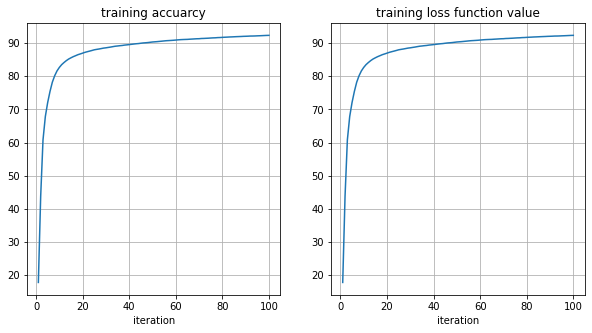

In [28]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(np.arange(1,epoch_num+1),np.mean(accuracy_training.cpu().numpy(),axis=0))
ax[1].plot(np.arange(1,epoch_num+1),np.mean(accuracy_training.cpu().numpy(),axis=0))
ax[0].set_title('training accuarcy')
ax[0].set_xlabel('iteration')
ax[1].set_title('training loss function value')
ax[1].set_xlabel('iteration')
ax[0].grid(True)
ax[1].grid(True)

In [29]:
import pandas as pd

# accuracy on test data

batch_size = 1
batch_num = int(x_te_norm.shape[0]/batch_size)
im_size = 15*15
input_layer = x_te_norm.reshape((batch_num,batch_size,im_size))
accuracy_training = torch.zeros((batch_num), device=dev)
loss_training = torch.zeros((batch_num), device=dev)

for i in range(batch_num):
    # forward
    z1 = torch.matmul(input_layer[i,:,:],w0) + b1
    hidden_layer1 = torch.tanh(ReLU(z1))
    z2 = torch.matmul(hidden_layer1,w1) + b2
    hidden_layer2 = torch.tanh(ReLU(z2))
    z3 = torch.matmul(hidden_layer2,w2) + b3
    hidden_layer3 = torch.tanh(ReLU(z3))
    z4 = torch.matmul(hidden_layer3,w3) + b4
    hidden_layer4 = torch.tanh(ReLU(z4))
    z5 = torch.matmul(hidden_layer4,w4) + b5
    output_layer = torch.tanh(ReLU(z5))

    # binarize output
    n = 5
    output_layer_binarized = binarize_output(output_layer,n,categories_nhot)
    
    # loss val and accuracy
    loss_training[i] = loss_function(output_layer_binarized,y_test_nhot[i*batch_size:(i+1)*batch_size,:])
    accuracy_training[i] = accuracy_cal(output_layer_binarized,y_test_nhot[i*batch_size:(i+1)*batch_size,:]);

print('accuracy: ',torch.mean(accuracy_training),' | loss value: ', torch.mean(loss_training))
print('done!')

accuracy:  tensor(92.0400, device='cuda:0')  | loss value:  tensor(0.3980, device='cuda:0')
done!


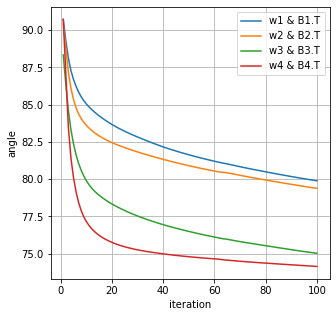

In [30]:
# angle between backward weights and forward weights
fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.plot(np.arange(1,epoch_num+1),np.mean(alignment[0,:,:].cpu().numpy(),axis=0))
ax.plot(np.arange(1,epoch_num+1),np.mean(alignment[1,:,:].cpu().numpy(),axis=0))
ax.plot(np.arange(1,epoch_num+1),np.mean(alignment[2,:,:].cpu().numpy(),axis=0))
ax.plot(np.arange(1,epoch_num+1),np.mean(alignment[3,:,:].cpu().numpy(),axis=0))


ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.legend(['w1 & B1.T','w2 & B2.T','w3 & B3.T','w4 & B4.T'],loc='best')
ax.grid(True)

In [35]:
# alignment terms calculation

batch_size = 1000
batch_num = 60
layer_num = 4
im_size = 15*15
epoch_num = 100
iter_needed = 631
input_layer = x_tr_norm.reshape((batch_num,batch_size,im_size))
a = alignment_term_cal(iter_needed,batch_num,layer_num,LR,B1,B2,B3,B4,delta5_inTime,delta4_inTime,delta3_inTime,\
                      delta2_inTime,delta1_inTime,input_layer,hidden_layer1_inTime,hidden_layer2_inTime,\
                      hidden_layer3_inTime,hidden_layer4_inTime)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106


RuntimeError: ignored

In [ ]:
# cal angles between alignment terms and backwart weights.T
angles_alignment_terms = np.zeros((len(a),4))

T_k = a[-1]
for i in range(T_k.shape[0]):
    T_o = np.squeeze(T_k[i,:,:,:])
    angles_alignment_terms[i,0] = angleCal(T_o[0,:,:],B1.T)
    angles_alignment_terms[i,1] = angleCal(T_o[1,:,:],B2.T)
    angles_alignment_terms[i,2] = angleCal(T_o[2,:,:],B3.T)
    angles_alignment_terms[i,3] = angleCal(T_o[3,:,:],B4.T)


(59, 4)


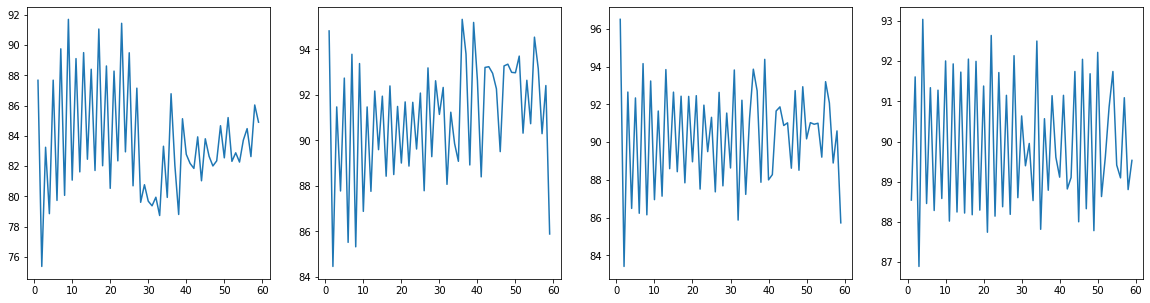

In [ ]:
print(angles_alignment_terms.shape)
fig, ax = plt.subplots(1,4,figsize=(20,5))

ax[0].plot(np.arange(1,60),angles_alignment_terms[:,0])
ax[1].plot(np.arange(1,60),angles_alignment_terms[:,1])
ax[2].plot(np.arange(1,60),angles_alignment_terms[:,2])
ax[3].plot(np.arange(1,60),angles_alignment_terms[:,3])

